In [70]:
import env
import gymnasium as gym 
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [71]:
# load training data - 1-min sampling rate
file_path = os.path.abspath('')
parent_path = os.path.dirname(file_path)
data_path = os.path.join(parent_path, 'data/disturbance_1min.csv')
data = pd.read_csv(data_path, index_col=[0])
index = range(0, len(data)*60, 60)
data.index = index

# sample every hour
dt = 3600
data = data.groupby([data.index // dt]).mean()
n = len(data)

In [72]:
data.head()


,out_temp,qint_lump,qhvac_lump,qwin_lump,qradin_lump,weighted_average
0,21.118333,0.440416,-3.909012,0.0,0.012347,23.036480
1,22.098333,0.430104,0.000000,0.0,0.012347,25.051452
2,21.949167,0.426729,0.000000,0.0,0.012347,25.191672
3,21.798333,0.424369,0.000000,0.0,0.012347,25.244827
4,21.700000,0.407597,0.000000,0.0,0.012347,25.266527


In [73]:
disturbance_names = ['out_temp', 'qint_lump', 'qwin_lump', 'qradin_lump']
disturbance = data[disturbance_names].values

u = data['qhvac_lump'].values

In [74]:
# test rc state space
rc_params = [10383.181640625, 499116.65625, 1321286.5, 1.53524649143219, 0.5000227689743042, 1.0003612041473389, 20.09742546081543]
x0 = np.array([23, 36, 25])
x_high = np.array([40., 80., 40.])
x_low = np.array([10., 10., 10.])
n_actions = 1201
u_high = [0]
u_low = [-12.0]

t_d = [t*dt for t in range(n)]


In [75]:
A = np.array([[-1.97402551e-04,  0.00000000e+00,  1.92610415e-04],
       [ 0.00000000e+00, -3.30784418e-06,  2.00281620e-06],
       [ 1.51360733e-06,  7.56564853e-07, -2.27017218e-06]])
Bu = np.array([[9.63095932e-05], [0.], [0.]])
Bd = np.array([[4.79213586e-06, 9.63095932e-05, 0.00000000e+00, 0.00000000e+00],
       [1.30502798e-06, 0.00000000e+00, 2.00353963e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.56838127e-07]])
C = np.array([[1., 0., 0.],
       [0., 0., 0.]])
D = np.array([[0.],
            [1.]])

In [76]:
# test linear state space gym env
import env.r4c3_discrete as rc

disturbances = [t_d, disturbance]

dist_fcn = rc.LinearInterpolation(*disturbances)
lssm = gym.make("DiscreteLinearStateSpace-v0",
                A = A,
                Bu = Bu, 
                Bd = Bd,
                C = C,
                D = D,
                x0 = x0,
                dist_fcn = dist_fcn,
                x_high = x_high,
                x_low = x_low,
                n_actions = n_actions,
                u_high = u_high,
                u_low = u_low,
                ts = 0,
                te = dt*24.,
                dt = dt).env

state0, _ = lssm.reset(seed=0)
assert lssm.observation_space.shape[0] == lssm.state.shape[0], "state shape does not match observation space shape"
assert lssm.action_space.n == n_actions, "action space does not match n_actions"
assert lssm.t == lssm.ts, "initial time does not match given start time"
assert np.any(lssm.state.astype(np.float32) == state0), "initial state does not match given initial state"

# sample actions from action space
# step 1
lssm.action_space.seed(12)
action = lssm.action_space.sample() # sample action from action space
state1, reward1, done1, _, _ = lssm.step(action) # step the environment
assert lssm.t == lssm.ts + lssm.dt, "time does not match given time step"
assert done1 == lssm.done, "done does not match environment done"
assert reward1 == 1, "reward does not match given reward"
assert np.any(lssm.state.astype(np.float32) == state1), "state does not match given state"

# step 2
action = lssm.action_space.sample()
state2, reward2, done2, _, _ = lssm.step(action)
assert lssm.t == lssm.ts + 2*lssm.dt, "time does not match given time step"
assert done2 == lssm.done, "done does not match environment done"
assert reward2 == 1, "reward does not match given reward"
assert np.any(lssm.state.astype(np.float32) == state2), "state does not match given state"

# reset environment
state3, _ = lssm.reset(seed=0)
assert lssm.t == lssm.ts, "time does not match given start time"
assert np.any(lssm.state.astype(np.float32) == state3), "state does not match given state"
assert np.any(state3 == state0), "state does not previous initial state"

/opt/conda/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:181: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [77]:
env = gym.make("R4C3Discrete-v0",
    rc_params = rc_params,
    x0 = x0,
    x_high = x_high,
    x_low = x_low,
    n_actions = n_actions,
    u_high = u_high,
    u_low = u_low,
    disturbances = (t_d, disturbance),
    ts = 0,
    te = 24*7.*2*dt,
    dt = dt).env

obs0, _ = env.reset(seed=0)
assert env.observation_space.shape[0] == env.observation.shape[0], "observation shape does not match observation space shape"


# step
env.action_space.seed(0)
action1 = env.action_space.sample()
obs1, reward1, terminated, _, _ = env.step(action1)
assert env.t == env.ts + env.dt*1, "time does not match given time step"
assert terminated == env.done, "done does not match environment done"
assert reward1 <= 0, "reward does not match the reward range"

# step
action2 = env.action_space.sample()
obs2, reward2, terminated, _, _ = env.step(action2)
assert env.t == env.ts + env.dt*2, "time does not match given time step"
assert terminated == env.done, "done does not match environment done"
assert reward2 <= 0, "reward does not match the reward range"

# reset
obs3, _ = env.reset(seed=0)
assert env.t == env.ts, "time does not match given start time"
assert np.any(env.observation.astype(np.float32) == obs3), "state does not match given state"
assert np.any(obs3 == obs0), "state does not previous initial state"


env is reset!
env is reset!


/opt/conda/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [78]:
# test continuous simulation
obs, _ = env.reset(seed=0)

i = 0
done = False

Tz = [obs[1]]
q_hvac = [0.]
while i < n and not done:
    action = (u[i] - np.array(u_low))*(n_actions - 1) / (np.array(u_high) - np.array(u_low))
    action = int(action)
    print(u[i], action)
    obs, reward, done, _, _ = env.step(action)
    Tz.append(obs[1])
    q_hvac.append(u[i])
    
    i += 1


env is reset!
-3.909011583503724 809
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
-0.008112508783001288 1199
-0.1795707385732975 1182
-7.049829225505723 495
-5.751299873544396 624
-4.347338930665189 765
-3.667525614615987 833
-3.615029677453877 838
-3.39209038667379 860
-3.3527780409798345 864
-3.2431797200190573 875
-2.8611788167807473 913
-2.7238136544326124 927
-0.29386119041929604 1170
-0.29540834784551434 1170
-0.4682965790873039 1153
-0.013543364561231497 1198
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
-0.5052745927624624 1149
-0.881911836868753 1111
-0.7779355346036751 1122
-6.2516480825408625 574
-4.5482429147180925 745
-3.9387590976295637 806
-3.695149356636911 830
-3.6822072828846584 831
-3.6848629866675373 831
-4.035602465096621 796
-4.273298845137207 772
-4.46004093029695 753
-4.495994171073726 750
-0.17735549588802177 1182
0.0 1200
-0.006777100384603763 1199
-0.0021887552654918383 1199
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
-0.81

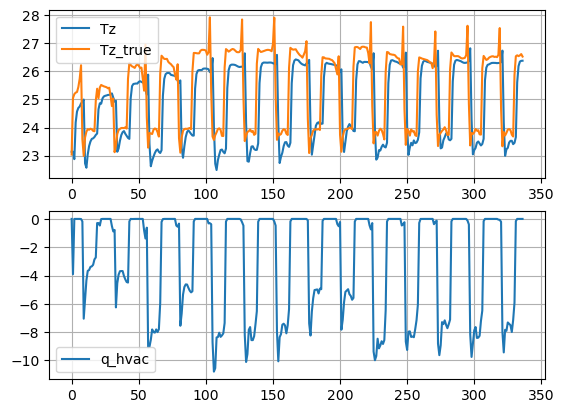

In [79]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(Tz, label="Tz")
plt.plot(data['weighted_average'][:len(Tz)], label="Tz_true")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(q_hvac, label="q_hvac")
plt.grid()
plt.legend()
plt.savefig('simulation.png')
